In [49]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from scipy import sparse, stats
import utils.text_processing as util

In [50]:
#Parameters
OUTPUT_CLASSES = 22
FILE_NAME = "../Data/processed_data.csv"
SEQUENCE_LENGTH = 150
EMBEDDING_SIZES =[300,300]
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.2
TEST_SIZE_PERCENTAGE = 0.2
Y_LABEL_NAME="username"
COV_FILTERS = [300,350,250,250]
FILTER_SIZES = [1,2,3,3]
NUMBER_K_FOLDS = 3



In [51]:
def define_model(input_len, output_size, vocab_sizes, embedding_dims, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'tanh', pool_size = 2, learning = 0.0005):

   # Sub network 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_sizes[0], embedding_dims[0])(inputs1)
    conv1_1 = Conv1D(filters = COV_FILTERS[0], kernel_size = FILTER_SIZES[0], activation = activation_fn)(embedding1)
    conv1_2 = Conv1D(filters = COV_FILTERS[1], kernel_size = FILTER_SIZES[1], activation = activation_fn)(conv1_1)
    conv1_3 = Conv1D(filters = COV_FILTERS[2], kernel_size = FILTER_SIZES[2], activation = activation_fn)(conv1_2)
    conv1_4 = Conv1D(filters = COV_FILTERS[3], kernel_size = FILTER_SIZES[3], activation = activation_fn)(conv1_3)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1_4)
    flat1 = Flatten()(pool1)
    
    # Sub network 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_sizes[1], embedding_dims[0])(inputs2)
    conv2_1 = Conv1D(filters = COV_FILTERS[0], kernel_size = FILTER_SIZES[0], activation = activation_fn)(embedding2)
    conv2_2 = Conv1D(filters = COV_FILTERS[1], kernel_size = FILTER_SIZES[1], activation = activation_fn)(conv2_1)
    conv2_3 = Conv1D(filters = COV_FILTERS[2], kernel_size = FILTER_SIZES[2], activation = activation_fn)(conv2_2)
    conv2_4 = Conv1D(filters = COV_FILTERS[3], kernel_size = FILTER_SIZES[3], activation = activation_fn)(conv2_3)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2_4)
    flat2 = Flatten()(pool2)
 

    # Merge channels
    merged = concatenate([flat1, flat2])
    
    # Create output layer
    dense = Dense(400, activation = 'sigmoid')(merged)
    output = Dense(output_size, activation = 'softmax')(dense)

    # Create model
    model = Model(inputs = [inputs1, inputs2], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [52]:
#Read data
data = pd.read_csv(FILE_NAME)

In [53]:
#Get text and y label
text = data['raw_text']
author = data['username']

In [54]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [55]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(22298,)
(5575,)
(22298,)
(5575,)


In [56]:
# Determine vocab sizes for n-grams
vocab_sizes = []
for i in range(1, 5):
    vocab_size = util.get_vocab_size(text_train, i, SEQUENCE_LENGTH)
    vocab_sizes.append(vocab_size)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 661
Vocab size for n = 2 is: 10079
Vocab size for n = 3 is: 89675
Vocab size for n = 4 is: 206674


In [57]:
gram1_train = util.create_n_grams(text_train, 1, vocab_sizes[0], SEQUENCE_LENGTH)
gram2_train = util.create_n_grams(text_train, 2, vocab_sizes[1], SEQUENCE_LENGTH)
gram3_train = util.create_n_grams(text_train, 3, vocab_sizes[2], SEQUENCE_LENGTH)


gram1_test = util.create_n_grams(text_test, 1, vocab_sizes[0], SEQUENCE_LENGTH)
gram2_test = util.create_n_grams(text_test, 2, vocab_sizes[1], SEQUENCE_LENGTH)
gram3_test = util.create_n_grams(text_test, 3, vocab_sizes[2], SEQUENCE_LENGTH)

In [58]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  858
Maximum encoding value for 2-grams is:  13102
Maximum encoding value for 3-grams is:  116574


In [59]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [60]:
# Model 1 Sensitivity Testing
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(gram3_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    siamese_model = define_model(SEQUENCE_LENGTH, OUTPUT_CLASSES, [max_3gram + 1,max_3gram + 1], EMBEDDING_SIZES, verbose = False)
    histroy = siamese_model.fit([train_x, train_x], train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = 0,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = siamese_model.predict([gram3_test, gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1


C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


175/175 [==============================] - 8s 47ms/step
Run: 2


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


175/175 [==============================] - 8s 44ms/step
Run: 3


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


175/175 [==============================] - 8s 46ms/step
Test Accuracy: [0.590134529147982, 0.5612556053811659, 0.5955156950672645]
Ave. Precision: [0.6010955076569152, 0.5756989523837966, 0.6245974189184553]
Ave. Recall: [0.5901345291479821, 0.561255605381166, 0.5955156950672646]
Ave. F1 Score: [0.5803741028243551, 0.5548081607684906, 0.6034721856013809]


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.5823019431988041
Average Precision across K-folds: 0.6004639596530558
Average Recall across K-folds: 0.5823019431988042
Average F1 Score across K-folds: 0.5795514830647422
Average Training Time across K-folds: 2169.809787273407 seconds
Prediction Time across K-folds: 8.250019311904907 seconds


In [62]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


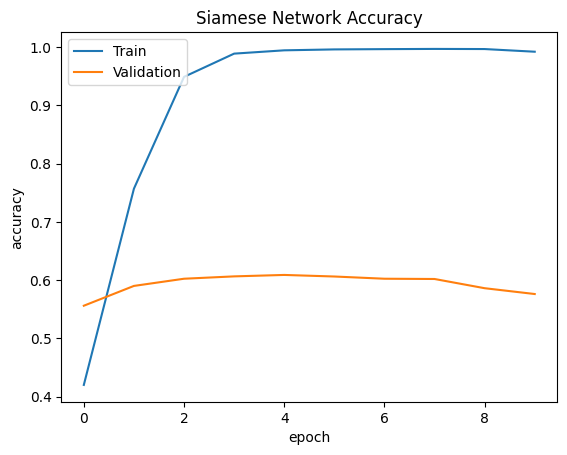

In [63]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Siamese Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/siamases_network_acc.eps", format='eps')
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


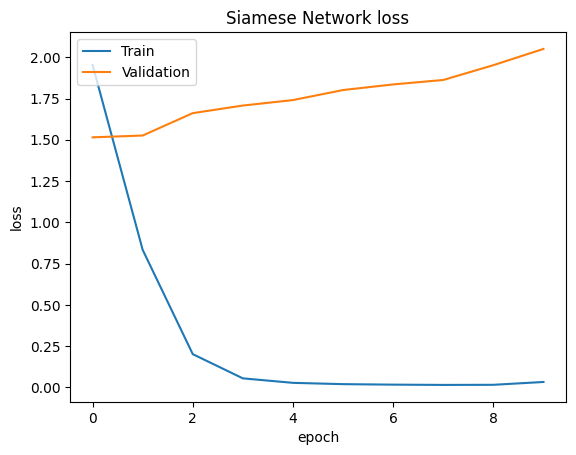

In [64]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Siamese Network loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/siamese_network_loss.eps", format='eps')
plt.show()
